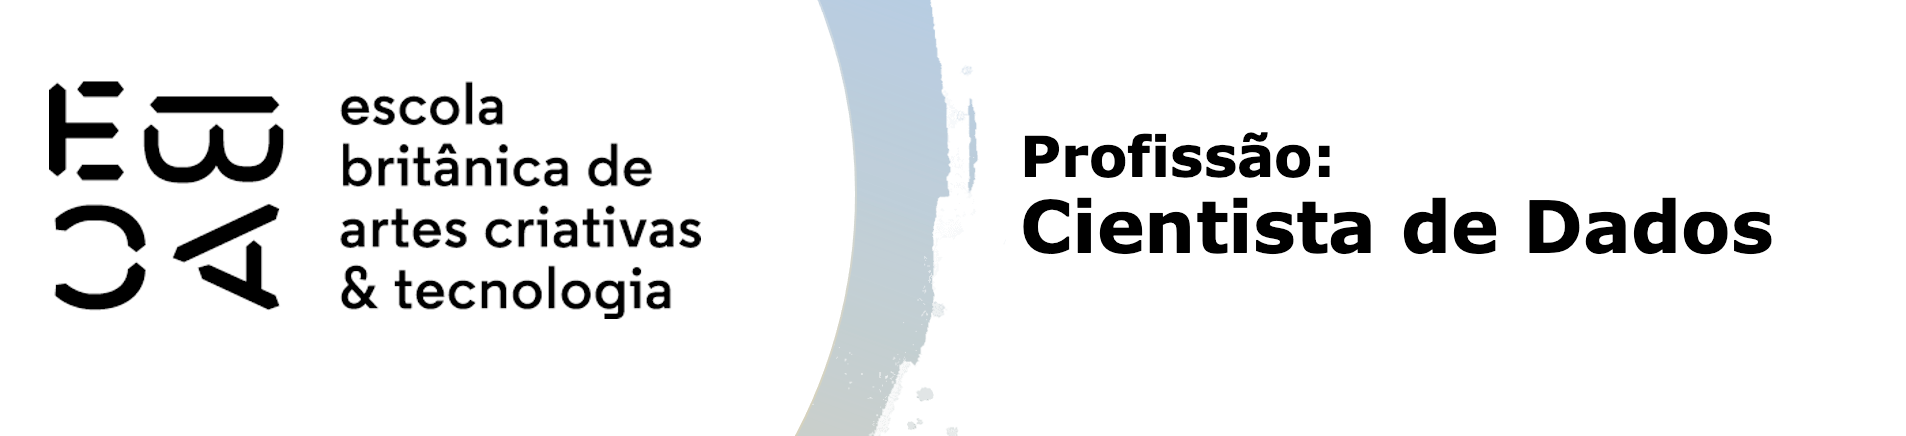

In [140]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# Tarefa II

Este projeto, é uma continuação da tarefa anterior. Estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

A ideia aqui, diferente do passo a passo feito na tarefa anterior, é criar um pipeline para automatizar e melhor alguns processos de pré-processamento e construção do modelo, além de garantir a reprodução correta dos passos a passos para bases ainda não utilizadas, como é o caso da base de treino. 

Iniciaremos carregando a base de dados ```credit_scoring.ftr```.

In [141]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


### TAREFA A 
#### Criação de um pipeline utilizando o sklearn pipeline para o pré processamento que englobe:
- Substituição de nulos;
- Remoção de outliers;
- Seleção de variáveis;
- Redução de dimensionalidade (PCA);
- Criação de dummies.

In [142]:
train.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos               float64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

#### Substituição de Nulos:

In [143]:
# Transformador para substituição de nulos pela média
class ImputeMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.imputer = SimpleImputer(strategy='mean')
        self.imputer.fit(X.select_dtypes(include=['number']))
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy[X_copy.select_dtypes(include=['number']).columns] = self.imputer.transform(X_copy.select_dtypes(include=['number']))
        return X_copy

#### Identificação e Remoção de Outliers:

In [144]:
# Transformador para identificação e remoção de outliers
class RemoveOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.5):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        numeric_cols = X_copy.select_dtypes(include=['number']).columns
        Q1 = X_copy[numeric_cols].quantile(0.25)
        Q3 = X_copy[numeric_cols].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - self.threshold * IQR
        upper_bound = Q3 + self.threshold * IQR
        return X_copy[~((X_copy[numeric_cols] < lower_bound) | (X_copy[numeric_cols] > upper_bound)).any(axis=1)]

#### Seleção das Features:

In [145]:
# Transformador para seleção de variáveis com base na importância
class FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, target_column, n_features=10):
        self.target_column = target_column
        self.n_features = n_features
    
    def fit(self, X, y=None):
        X_copy = X.drop(columns=[self.target_column])
        y = X[self.target_column]
        self.model = RandomForestClassifier(random_state=42)
        self.model.fit(X_copy, y)
        importances = self.model.feature_importances_
        self.important_features = X_copy.columns[np.argsort(importances)[-self.n_features:]]
        return self
    
    def transform(self, X):
        return X[self.important_features]


#### Redução de Dimensionalidade (PCA - Análise de Componentes Principais):

In [146]:
# Transformador para redução de dimensionalidade (PCA)
class DimensionalityReduction(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=5):
        self.n_components = n_components
    
    def fit(self, X, y=None):
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(X.select_dtypes(include=['number']))
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        numeric_cols = X_copy.select_dtypes(include=['number']).columns
        X_copy_pca = self.pca.transform(X_copy[numeric_cols])
        return pd.DataFrame(X_copy_pca)

#### Criação das dummies:

In [147]:
# Transformador para criação de variáveis dummies
class CreateDummies(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.get_dummies(X, drop_first=True)

#### Pipeline de pré processamento:

In [148]:
# Criando o pipeline de processamento
def create_pipeline(target_column, n_features=10, n_components=5, outlier_threshold=1.5):
    processing_pipeline = Pipeline([
        ('impute_missing', ImputeMissingValues()),
        ('create_dummies', CreateDummies()),
        ('remove_outliers', RemoveOutliers(threshold=outlier_threshold)),
        ('feature_selection', FeatureSelection(target_column=target_column, n_features=n_features)),
        ('dimensionality_reduction', DimensionalityReduction(n_components=n_components))
        ])
    return processing_pipeline

Para reduzir o tempo de processamento, iremos utilizar uma amostra de 50 mil observações.

In [149]:
#criando uma amostra de 50000
data = df.sample(50000)

In [150]:
# Separando os conjuntos de treinamento e teste com base na OOT:
train = data[data['data_ref'] <= '2015-12-31']  # Até dezembro de 2015
test = data[data['data_ref'] >= '2016-01-01']   # A partir de janeiro de 2016

In [151]:
train = train.drop(columns=['data_ref', 'index'])
test = test.drop(columns=['data_ref', 'index'])

In [152]:
print(train.shape)
print(test.shape)

(39953, 13)
(10047, 13)


Agora que dividimos em treino e teste as nossas amostras, vamos utilizar o pipeline criado contendo as funções acima. Faremos o mesmo para treino e teste.

In [153]:
# Exemplo de uso:
pipeline = create_pipeline(target_column='mau', n_features=10, n_components=5, outlier_threshold=1.5)
train_processed = pipeline.fit_transform(train)
train_processed.head()

,0,1,2,3,4
0,5995.297094,13.388698,2.640247,-0.799683,0.425696
1,-6826.415038,-12.100823,1.116002,0.599265,-0.045157
2,-7921.263572,10.021336,0.512325,-0.065145,-0.192918
3,-4609.512827,19.857532,0.639229,0.254394,-0.161370
4,16459.316885,10.649558,1.638833,-0.064540,-0.170341


In [154]:
test_processed = pipeline.fit_transform(test)
test_processed.head()

,0,1,2,3,4
0,4532.822667,16.195996,2.664368,-0.552701,0.433023
1,-1728.903556,-1.339002,1.951646,1.018368,-0.015718
2,-2223.325898,17.167388,-1.744837,-0.660740,0.415056
3,-2159.418042,-13.359582,3.324765,0.647788,-0.048392
4,-2679.535894,-15.847247,-1.324210,-0.954678,-0.267065


A seguir, rodaremos um modelo e posteriormente, avaliaremos como se sai na base de teste, por isso, pré-processamos também os dados de teste, para que fiquem no mesmo formato dos dados de treino. 

### TAREFA B
#### Pycaret na base de dados 

Utilizaremos o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Após avaliar o modelo, geraremos um pipeline. 



In [155]:
#carregando a base:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [156]:
#criando uma amostra de 50000:
data = df.sample(50000)

In [157]:
# Separando os conjuntos de treinamento e teste com base na OOT:
train = data[data['data_ref'] <= '2015-12-31']  # Até dezembro de 2015
test = data[data['data_ref'] >= '2016-01-01']   # A partir de janeiro de 2016

In [158]:
#excluindo data_ref e index:
train = train.drop(columns=['data_ref', 'index'])
test = test.drop(columns=['data_ref', 'index'])

Com nossas amostras prontas, vamos iniciar o uso do pycaret:

In [159]:
from pycaret.classification import *

# Inicializando o ambiente do PyCaret
exp = setup(data=train, target='mau', session_id=123)

# Listando os modelos disponíveis
models()


,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(39936, 13)"
4,Transformed data shape,"(39936, 30)"
5,Transformed train set shape,"(27955, 30)"
6,Transformed test set shape,"(11981, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.4%


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [160]:
train.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [161]:
#forçando a variável qnt de filhos como numérica
train.qtd_filhos = data.qtd_filhos.astype(float)

In [162]:
exp_clf101 = setup(data = train, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(39936, 13)"
4,Transformed data shape,"(39936, 30)"
5,Transformed train set shape,"(27955, 30)"
6,Transformed test set shape,"(11981, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.4%


Dentre os modelos que podemos utilizar, disponibilizados em uma das tabelas acima, iremos escolher o modelo **lightgbm** *que é o indicado pelo exercício*:

In [163]:
#criando o modelo:
lightgbm = create_model('lightgbm', class_weight='balanced')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7264,0.7216,0.6190,0.1292,0.2138,0.1270,0.1849
1,0.7321,0.7413,0.5655,0.1232,0.2023,0.1150,0.1639
2,0.7454,0.7428,0.5833,0.1324,0.2159,0.1307,0.1826
3,0.7260,0.7650,0.6488,0.1336,0.2215,0.1354,0.1985
4,0.7436,0.7457,0.5952,0.1335,0.2181,0.1330,0.1869
5,0.7374,0.7807,0.6826,0.1434,0.2370,0.1534,0.2225
6,0.7352,0.7201,0.5714,0.1257,0.2060,0.1192,0.1691
7,0.7317,0.7097,0.5179,0.1151,0.1883,0.0998,0.1408
8,0.7138,0.7401,0.6310,0.1256,0.2095,0.1214,0.1812


Agora que criamos o modelo, **vamos otimizar o F1-score, uma métrica que equilibra precisão (proporção de previsões positivas corretas) e recall (capacidade de identificar os casos positivos).**

In [164]:
#otimizando o F1, buscar o melhor parâmetro pra encontrar o melhor F1
tuned_gbm = tune_model(lightgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7643,0.7358,0.5417,0.1352,0.2164,0.1330,0.1780
1,0.7732,0.7526,0.5952,0.1502,0.2398,0.1591,0.2119
2,0.7754,0.7407,0.5417,0.1417,0.2247,0.1431,0.1876
3,0.7554,0.7781,0.6548,0.1495,0.2434,0.1613,0.2248
4,0.7639,0.7415,0.5298,0.1328,0.2124,0.1287,0.1719
5,0.7649,0.7622,0.6048,0.1460,0.2352,0.1537,0.2086
6,0.7710,0.7267,0.5179,0.1347,0.2138,0.1308,0.1720
7,0.7635,0.7190,0.4940,0.1259,0.2007,0.1160,0.1539
8,0.7521,0.7361,0.5714,0.1339,0.2169,0.1325,0.1823


Fitting 10 folds for each of 10 candidates, totalling 100 fits


A otimização melhorou a capacidade do modelo de encontrar casos positivos (maior recall), mas com um leve custo na separação das classes (queda no AUC). O aumento no F1-score e MCC mostra que o ajuste foi positivo.

A seguir, vamos plotar alguns gráficos que nos permitem visualizar o comportamento das métricas obtidas com o modelo:

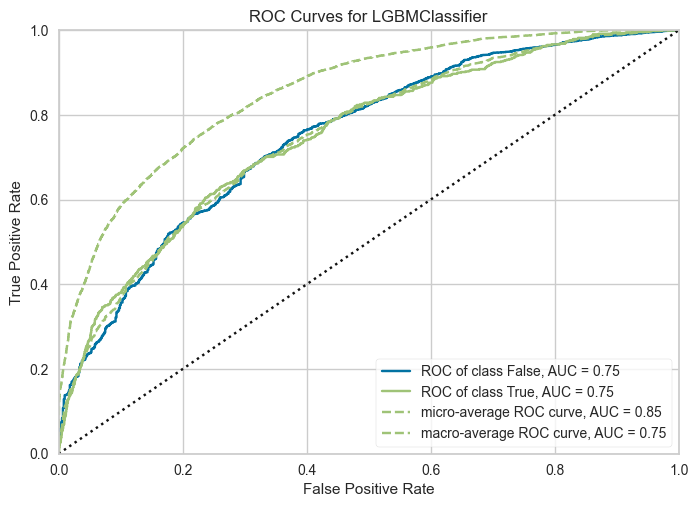

In [165]:
#curva ROC:
plot_model(tuned_gbm, plot = 'auc')

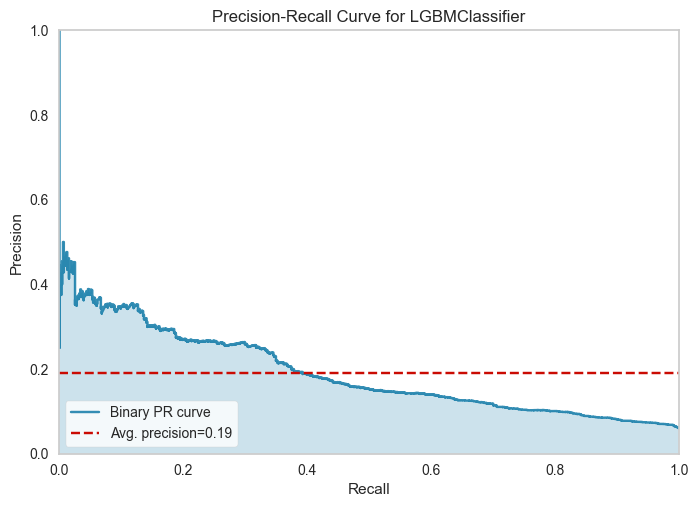

In [166]:
#precision recall:
plot_model(tuned_gbm, plot = 'pr')

Desempenho Geral do Modelo: 
- **ROC Curve:** O valor de AUC (Area Under the Curve) de 0.69 para ambas as classes ("True" e "False") indica que o modelo tem uma capacidade moderada de distinguir entre as classes. A micro-média (AUC = 0.57) indica que, ao considerar todas as classes juntas, o desempenho do modelo é mais fraco, o que pode ser um sinal de desequilíbrio entre as classes e a macro-média (AUC = 0.69) confirma que o desempenho médio entre as classes é consistente, mas ainda moderado.

- **Precision-Recall Curve:** A precisão média de 0.11 é muito baixa, o que indica que o modelo tem dificuldade em equilibrar precisão e revocação. Isso é comum em problemas com classes desbalanceadas, onde o modelo pode estar tendendo a prever a classe majoritária, resultando em baixa precisão para a classe minoritária.

Talvez em um segundo momento seria mais interessante utilizar outros modelos, mas por hora e por efeito desse exercício, prosseguiremos com esse. A seguir, vamos plotar um gráfico indicando a importancia das variáveis para o modelo:

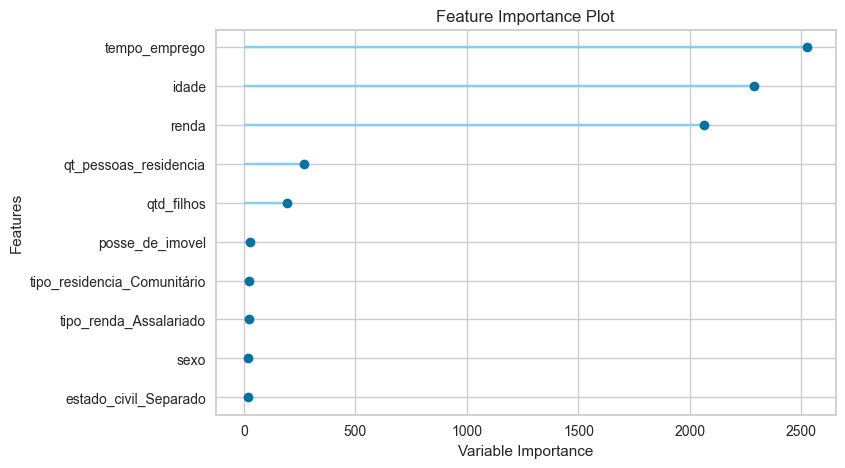

In [167]:
plot_model(tuned_gbm, plot='feature')

Podemos ver que a variável renda é de fato a unica e mais importante para o modelo. Provavelmente isso se deve ao fato de estarmos utilizando apenas uma amostra.
A seguir, vejamos a matriz de confusão:

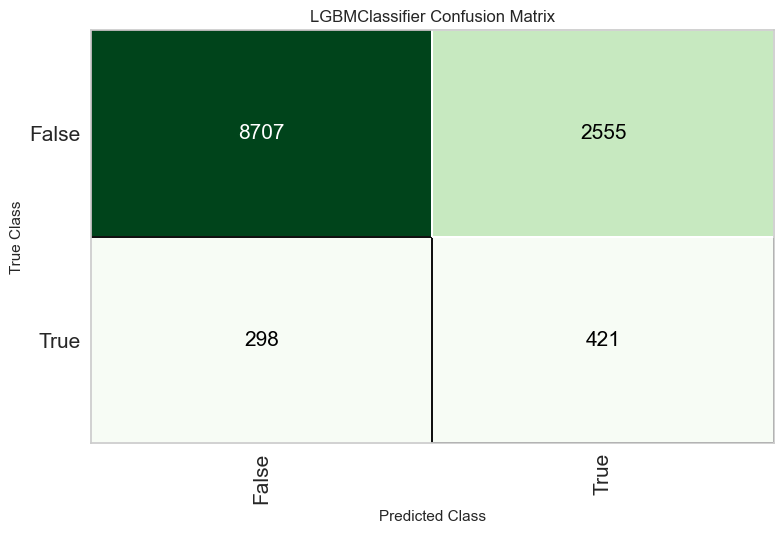

In [168]:
plot_model(tuned_gbm, plot = 'confusion_matrix')

Apesar de não termos uma classificação muito precisa aqui, vamos salvar o modelo e criar o pipeline para ele:

In [169]:
#modelo final
final_gbm = finalize_model(tuned_gbm)
print(final_gbm)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                boosting_type='gbdt', class_weight='balanced',
                     

In [170]:
predict_model(final_gbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7799,0.8568,0.7886,0.1858,0.3007,0.2255,0.3096


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


#### Predizendo o conjunto de dados que não foi usado no treino:

In [171]:
unseen_predictions = predict_model(final_gbm, data=test)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.4673,0.7247,0.8542,0.1997,0.3237,0.1079,0.1881


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
709238,F,N,S,0,Pensionista,Fundamental,Casado,Casa,68,NaN,2.0,2260.419922,True,1,0.5026
735448,F,N,S,1,Assalariado,Médio,Casado,Casa,46,2.619178,3.0,952.479980,True,1,0.5048
708004,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,1456.130005,True,1,0.5039
720672,F,N,N,0,Assalariado,Médio,Casado,Casa,30,4.301370,2.0,1326.089966,True,1,0.5031
643338,F,N,N,1,Empresário,Médio,Casado,Casa,31,8.301370,3.0,3882.669922,False,0,0.5009


Temos um modelo que classifica bem aoenas 46% das vezez

### Salvando o Modelo Final e criando o Pipeline:

In [172]:
#salvando o modelo e gerando o pipeline:
save_model(final_gbm,'Final GBM Model 11Fev2025')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight='balanced',
      